In [1]:
%cd results

/home/ec2-user/SageMaker/results


In [2]:
import os
import pandas as pd
import subprocess
import re
import glob

def get_single_result(file):
    file_base = file.split(".jsonl")[0]
    # print(file_base)
    try:
        os.remove(file_base+"_eval_results.json")
    except:
        pass
    # run evalplus.evaluate
    result = subprocess.run(["sudo", "/home/ec2-user/anaconda3/envs/pytorch_p39/bin/evalplus.evaluate",
                    "--dataset", "humaneval", "--samples", file, "--i-just-wanna-run"], 
                            text=True, capture_output=True, check=False)

    # print(result.stdout)
    # extract results from stdout
    regex = re.compile(r"'pass@1': ([0-9.]+)")
    matches = regex.findall(result.stdout)
    
    base = float(matches[0]) if matches else None
    base_extra = float(matches[1]) if matches else None

    to_add = {'file': [file], 'base': [base*100], 'base_extra': [base_extra*100]}
    print(to_add)
    new_row = pd.DataFrame(to_add)
    return new_row
        
def get_results_pd():
    print("starting")
    # list of jsonl files
    jsonl_files = sorted([file for file in os.listdir() if file.endswith('.jsonl')], key=str.lower)

    # results dataframe
    results_df = pd.DataFrame(columns=['file', 'base', 'base_extra'])

    # for each file
    for file in jsonl_files:
        to_add = get_single_result(file)

        results_df = pd.concat([results_df, to_add], ignore_index=True)
    return results_df

def get_recent_results(x):
    jsonl_files = [file for file in os.listdir() if file.endswith('.jsonl')]
    jsonl_files.sort(key=lambda file: os.path.getmtime(file), reverse=True)
    return jsonl_files[:x]

In [3]:
df = get_results_pd()

starting
{'file': ['Aeala_VicUnlocked-alpaca-65b-4bit_alpaca_long.jsonl'], 'base': [1.8292682926829267], 'base_extra': [1.8292682926829267]}
{'file': ['TheBloke_guanaco-33B-GPTQ_alpaca_short.jsonl'], 'base': [0.6097560975609756], 'base_extra': [0.6097560975609756]}
{'file': ['TheBloke_vicuna-7B-1.1-GPTQ-4bit-128g_vicuna_long.jsonl'], 'base': [1.8292682926829267], 'base_extra': [1.8292682926829267]}


In [4]:
df = df.rename(columns={'base': 'HumanEval', 'base_extra': 'Eval+'})

In [5]:
df.to_csv('results.csv', index=False)

In [6]:
df = pd.read_csv('results.csv')

df_sorted = df.sort_values(['Eval+', 'HumanEval'])
df_sorted.head()

,file,HumanEval,Eval+
1,TheBloke_guanaco-33B-GPTQ_alpaca_short.jsonl,0.609756,0.609756
0,Aeala_VicUnlocked-alpaca-65b-4bit_alpaca_long....,1.829268,1.829268
2,TheBloke_vicuna-7B-1.1-GPTQ-4bit-128g_vicuna_l...,1.829268,1.829268


In [7]:
recent = get_recent_results(5)
results_df = pd.DataFrame(columns=['file', 'base', 'base_extra'])

for file in recent:
    print(file)
    to_add = get_single_result(file)
    results_df = pd.concat([results_df, to_add], ignore_index=True)

results_df.head()

TheBloke_vicuna-7B-1.1-GPTQ-4bit-128g_vicuna_long.jsonl
{'file': ['TheBloke_vicuna-7B-1.1-GPTQ-4bit-128g_vicuna_long.jsonl'], 'base': [1.8292682926829267], 'base_extra': [1.8292682926829267]}
Aeala_VicUnlocked-alpaca-65b-4bit_alpaca_long.jsonl
{'file': ['Aeala_VicUnlocked-alpaca-65b-4bit_alpaca_long.jsonl'], 'base': [1.8292682926829267], 'base_extra': [1.8292682926829267]}
TheBloke_guanaco-33B-GPTQ_alpaca_short.jsonl
{'file': ['TheBloke_guanaco-33B-GPTQ_alpaca_short.jsonl'], 'base': [0.6097560975609756], 'base_extra': [0.6097560975609756]}


,file,base,base_extra
0,TheBloke_vicuna-7B-1.1-GPTQ-4bit-128g_vicuna_l...,1.829268,1.829268
1,Aeala_VicUnlocked-alpaca-65b-4bit_alpaca_long....,1.829268,1.829268
2,TheBloke_guanaco-33B-GPTQ_alpaca_short.jsonl,0.609756,0.609756


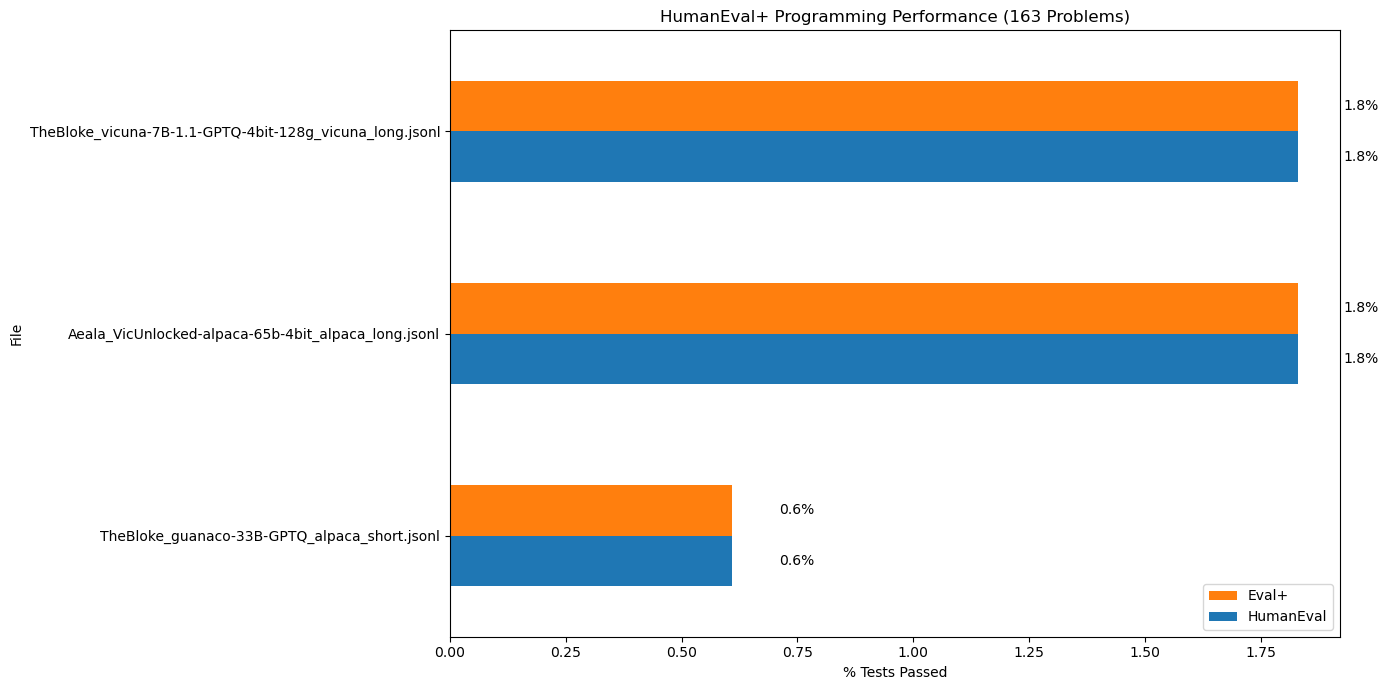

In [8]:
import matplotlib.pyplot as plt
import numpy as np
# Plot
fig, ax = plt.subplots(figsize=(14, 7))
df_sorted.plot(x='file', y=['HumanEval', 'Eval+'], kind='barh', ax=ax)

# Customize the plot
ax.set_xlabel('% Tests Passed')
ax.set_ylabel('File')
ax.set_title('HumanEval+ Programming Performance (163 Problems)')
# Reverse the order of legend labels
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1])

# Add labels at the ends of the bars
for p in ax.patches:
    width = p.get_width()
    plt.text(width + 0.1,  # add a small offset to avoid overlapping with the bar
             p.get_y() + p.get_height() / 2,
             '{:1.1f}%'.format(width),
             ha='left',
             va='center')

plt.tight_layout()  # Adjust subplot parameters to give specified padding
plt.show()


In [9]:
filtered_df = df[df['file'].str.contains('guanaco')]
